In [2]:
### PREAMBLE
# Free text processing
# text.png


## Introduction

This set of notes focuses on processing free text data.  In addition to the more structured relational data and graphs we have discussed previously, free text makes up one of the most common types of "widely available" data: web pages, unstructured "comment" fields in many relational databases, and many other easily-obtained large sources of data naturally come in free text form.  The notable difference, of course ,is that unlike the data types we have discussed before, free text lacks the "easily extractable" structure inherent in the previous types of data we have considered.

This is not to say, of course, that free text data lacks structure.  Just the opposite: by its very definition free text usually needs to have meaning to the people who are reading that data.  But the task of actually understanding this structure is a problem that is still beyond the scope of "generic" data science tools, because it often involves human-level intelligence (or at least bringing to bear an enormous amount of external context) to understand the meaning behind the text.  

This is also naturally a debatable point, and this particular perspective on free text data is one that may need to be reconsidered based upon advances in the upcoming years.  For instance, we will later in the course deal with algorithms for processing image data for data science tasks, but only after we have (briefly, at a very high level) covered some methods for deep learning; indeed, handling images will be one of the primary use cases for deep learning in data science.  And there are already some instances of these techniques that appear in this lecture too: the word2vec model (which is an addition to the lecture this year), _is_ in fact a neural network model that we will use to understand text data.

But the primary difference is that, in my opinion, it is still the case that _most_ tasks involving free text analysis in data science can be carried out using relatively simple methods that we can easily understand without any reference to complex machine learning: methods like bag-of-word models, TFIDF vectors, and (simple n-gram) language models.  It may be that some day soon "off-the-shelf" deep learning methods will be so superior to these approaches that there is no need to bother with anything else, but in my experience we are not quite there yet, so this lecture still focuses substantially on the simple approaches, even if it also mentions (without a full derivation) models like word2vec.


## Free text in data science

As mentioned above, the goal that we will consider here of using free text in data science is to extract some meaningful information from the text, _without_ any deep understanding of its meaning.  The reason for this is simple: extracting deep understanding from text is hard.


### Natural language processing/understanding
The general field of Natural Language Processing (some might differentiate between NLP and "natural language understanding", but for our purposes here you can think of these synonymously) looks to truly understand the structure behind free text, e.g. perform tasks like parse the sentences grammatically, describe the general entities and properties that the text is referring to, etc.  But it is easy to come up with examples of why this can be hard.  For example, consider he following example, known as a Winograd schema:

> The city councilmen refused the demonstrators a permit because they [feared/advocated] violence.

If you read the sentence:
 
> The city councilmen refused the demonstrators a permit because they feared violence.

then it is fairly obviously that the "they" here refers to the city councilmen; fearing violence would not be a reason for denying someone a permit, so clearly it is the councilmen that fear violence.  On the other hand, in the sentence

> The city councilmen refused the demonstrators a permit because they advocated violence.

the "they" term clearly applies to the demonstrators (the city councilmen presumably would not advocate for violence, let along deny someone a permit because they, the councilmen, were advocating violence).  The point of all this (and this was the original point of these examples, which were originally proposed by Terry Winograd in 1972) is that when we do something "simple", like parse a sentence, we bring to bear an enormous amount of outside knowledge and context to this action.  Unlike say, XML documents, there is no internally-specified format that makes language unambiguous; it could be unambiguous only because of external context and knowledge, or it could even be completely ambiguous.  Or in a different vein, there can be grammatically-incorrect sentences that still have clear syntactic meaning, and there can be grammatically-correct sentences that are meaningful.

### Free text in data science

Fortunately, for many data science tasks, we can still extract considerable information from text _while only understanding it at an extremely rudimentary level_.  Consider the following two reviews for the same movie:

> ... truly, a stunning exercise in large-scale filmmaking; a beautifully-assembled picture in which Abrams combines a magnificent cast with a marvelous flair for big-screen, sci-fi storytelling.

and

> It's loud and full of vim -- but a little hollow and heartless.

Understanding that the first review is positive, while the second review is negative, doesn't take any deep understand of the language itself, it can be done by simple keyword lookup: "stunning" and "marvelous" are associated with a positive review, while "hollow" and "heartless" are associated with negative reviews.  Now, of course it's possible to use more complex language to signify a positive review while using some "negative" words, with statements like, "not at all boring".  But people don't usually write exclusively in this manner (doing so would be "not at all clear"), so that the general sentiment of text can still come through very easily even with a few instances where the words themselves can throw you off.

With this as context, these notes cover three different examples of methods for extracting some information from free text, without truly understanding much of the language itself.  These methods are becoming standard tools in data science, and have the advantage of being relatively easy to set up and begin processing with.  These methods are:

1. Bag of words models and TDIDF vectors
2. Word embeddings and word2vec
3. N-gram language models

**Terminology:** Before we begin, a quick note on terminology.  In these notes "document" will mean an individual group of free text data (this could be an actual document or a text field in a database).  "Words" or "terms" refer to individual tokens separated by whitespace, and additionally also refers to puncutation (so we will often separate punctuation explicitly from the surounding words.  "Corpus" refers to a collection of documents, and we will sometimes refer to the set of all _unique_ words/tokens in the corpus as the "vocabulary".


## Bag of words models and TFIDF

The bag of words model is by far the most common means of representing documents in data science.  Under this model, a document is described soley by the set of words (and possibly their counts) that make up the document.  All information about the actual ordering of the words is ignored.  It is essentially the so-called "word cloud" view of a document.

In [101]:
import wordcloud
from bs4 import BeautifulSoup
import requests
import re

response = requests.get("https://aisaturdayslagos.github.io")

In [102]:
response

<Response [200]>

In [103]:
root = BeautifulSoup(response.content, "lxml")

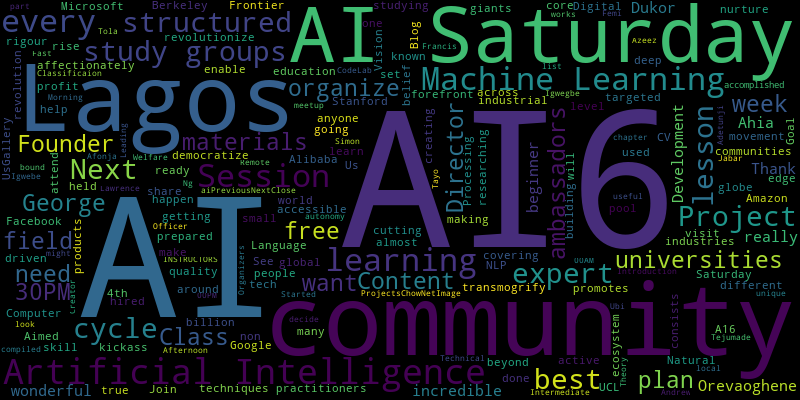

In [104]:
from wordcloud import WordCloud
wc = WordCloud(width=800,height=400).generate_from_text(re.sub(r"\s+"," ", root.text))
wc.to_image()

![Word cloud of text from the Practical Data Science home page.](wordcloud.png)

Despite the obvious information we are throwing away with this representation, it send to work surpringingly well in practice, for the precise reason we mentioned above, that the general "gist" of many documents can be obtained with only looking at the presence/absence of words in the text.

In these notes, we'll cover a simple example of creating so-called TFIDF vectors, which represent the documents via a (weighted) bag of words model. We will then then using these to compute the similarity between documents.  This technique is a common approach for applications like document retrieval and or search, though in the homework you will also experiment using TFIDF vectors as input to a machine learning algorithm.

### Term frequency

In our example, let's begin with our corpus that contains the following three documents:

In [129]:
documents = ["the goal of this lecture is to explain the basics of free text processing",
             "the bag of words model is one such approach",
             "text processing via bag of words"]

In this setting, we can represent the documents using a _term frequency_ matrix, and $m \times n$ matrix where $m$ denotes the number of documents, and $n$ denotes the vocabulary size (i.e., the number of unique words across all documents).  To see (the naive way of) how to construct this list, let's first consider a simple way to get a list of all unique words across all documents.  In general there is no need to actually sort the list of words, but we will do so for simplicity here.  It's a good idea to also generate a dictionary that maps words to their index in this list, as we'll frequently want to look up the index corresponding to a word.

In [130]:
document_words = [doc.split() for doc in documents]
vocab = sorted(set(sum(document_words, [])))
vocab_dict = {k:i for i,k in enumerate(vocab)}
print(document_words, "\n")
print(vocab, "\n")
print(vocab_dict, "\n")

[['the', 'goal', 'of', 'this', 'lecture', 'is', 'to', 'explain', 'the', 'basics', 'of', 'free', 'text', 'processing'], ['the', 'bag', 'of', 'words', 'model', 'is', 'one', 'such', 'approach'], ['text', 'processing', 'via', 'bag', 'of', 'words']] 

['approach', 'bag', 'basics', 'explain', 'free', 'goal', 'is', 'lecture', 'model', 'of', 'one', 'processing', 'such', 'text', 'the', 'this', 'to', 'via', 'words'] 

{'approach': 0, 'bag': 1, 'basics': 2, 'explain': 3, 'free': 4, 'goal': 5, 'is': 6, 'lecture': 7, 'model': 8, 'of': 9, 'one': 10, 'processing': 11, 'such': 12, 'text': 13, 'the': 14, 'this': 15, 'to': 16, 'via': 17, 'words': 18} 



In [131]:
len(vocab_dict)

19

Now let's construct a matrix that contains word counts (term frequencies) for all the documents.  We'll also refer to the term frequency of the $j$th word in the $i$th library as $\mathrm{tf}_{i,j}$.

In [132]:
import numpy as np
X_tf = np.zeros((len(documents), len(vocab)), dtype=int)
for i,doc in enumerate(document_words):
    for word in doc:
        X_tf[i, vocab_dict[word]] += 1
print(X_tf)

[[0 0 1 1 1 1 1 1 0 2 0 1 0 1 2 1 1 0 0]
 [1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1]]


As mentioned above, each of the _rows_ in this matrix correponds to one of the three documents above, and each column correponds to one of the 19 words.  Importantly, note that in practice (for instance on the homework), you will want to create term frequency matrices directly in sparse format, because the term frequency matrix is itself typically sparse (when there are a large number of documents, many words will only be contained in a small number of the document).

In this case, we had the entry in our term frequency matrix just correspond to the number of occurences of that term.  But there are other possibilities as well:

* The entry can be binary: 1 if the term occurs (any number of times), and 0 otherwise.  This somewhat mitigates the significance of common words that may occur very frequently.
* A nonlinear scaling, e.g. $\log (1+\mathrm{tf}_{i,j})$, which lies somewhere between the binary case and the raw counts.
* A scaled version of term frequencies, e.g., scaling by the maximum term frequency in the document, $\mathrm{tf}_{i,j} / \max_k \mathrm{tf}_{i,k}$.  (Note that this won't affect the actual similarity scores we'll discuss next, because we will ultimately scale each document but it affects the term frequency matrix itself, of course).

### Inverse document frequency

An obvious issue with using normal term frequency counts to represent a document is that the document's vector (and the resulting similarities we will consider) will often be "dominated" by very common words, for example: "of", "the", "is", in the preceeding example documents.  This issue can be mitigated to some extent by excluding so-called "stop words" (common English words like "the", "a", "of" that aren't considered relevant to the particular documents) from the term frequency matrix.  But this still ignores the case where a word that may not be a generic stop word still happens to occur in a very large number of documents.  Intuitively, we expect that the most "important" words in a document are precisely those that only occur in some relatively small number of documents, so that we want to discount the weight of very frequently-occurring terms.

This can be accomplished via the inverse document frequency weight for words.  Just as with term frequencies, there are some different weightings of this term, but the most common formulation is
\begin{equation}
\mathrm{idf}_j = \log\left(\frac{\mbox{# documents}}{\mbox{# documents with word $j$}}\right).
\end{equation}
As an example, if the word is contained in every document, then the inverse document frequency weight will be zero (log of one).  In contrast, if a word occurs in only one document, its inverse document frequency will be $\log (\mbox{# documents})$.

Note that inverse document frequency is a _per word_ term, as opposed to term frequency, which is _per word and document_.  We can compute inverse document frequency for our data set as follows, which mainly just requires counting how many documents contain each word.

In [136]:
X_tf.astype(bool).sum(axis=0)

array([1, 2, 1, 1, 1, 1, 2, 1, 1, 3, 1, 2, 1, 2, 2, 1, 1, 1, 2])

In [35]:
idf = np.log(X_tf.shape[0]/X_tf.astype(bool).sum(axis=0))
print(idf)

[1.09861229 0.40546511 1.09861229 1.09861229 1.09861229 1.09861229
 0.40546511 1.09861229 1.09861229 0.         1.09861229 0.40546511
 1.09861229 0.40546511 0.40546511 1.09861229 1.09861229 1.09861229
 0.40546511]


### TFIDF

The term frequency inverse document frequency (TFIDF) combination simply scales the columns of the term frequency matrix by their inverse document frequency.  In doing so, we still have an effective bag of words representation of each document, but we do so with the weighting implied by the inverse document frequency: discouting words that occur very frequently, and increasing the weight of less frequent terms.

In [44]:
X_tfidf = X_tf * idf
print(X_tfidf)

[[0.         0.         1.09861229 1.09861229 1.09861229 1.09861229
  0.40546511 1.09861229 0.         0.         0.         0.40546511
  0.         0.40546511 0.81093022 1.09861229 1.09861229 0.
  0.        ]
 [1.09861229 0.40546511 0.         0.         0.         0.
  0.40546511 0.         1.09861229 0.         1.09861229 0.
  1.09861229 0.         0.40546511 0.         0.         0.
  0.40546511]
 [0.         0.40546511 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.40546511
  0.         0.40546511 0.         0.         0.         1.09861229
  0.40546511]]


### Cosine similarity

Given a TFIDF (or just term frequency) matrix, one of the more common questions to address is to compute similarity between multiple documents in the corpus.  The common metric for doing so is to compute the cosine similarity between two different documents.  This is simply a normalize inner product between the vectors describing each documents.  Specifically,
\begin{equation}
\mbox{CosineSimilarity}(x,y) = \frac{x^T y}{\|x\|_2 \cdot \|y\|_2}.
\end{equation}
The cosine similarity is a number between zero (meaning the two documents share no terms in common) and one (meaning the two documents have the exact same term frequency or TFIDF representation).  In fact, the cosine similarity is exactly the converse of the squared Eucliean distance between the normalized document vectors; formally, for $\tilde{x} = x / \|x\|_2$ and $\tilde{y} = y / \|y\|_2$, 
\begin{equation}
\begin{split}
\frac{1}{2}\|\tilde{x} - \tilde{y}\|_2^2 & = \frac{1}{2}(\tilde{x} - \tilde{y})^T (\tilde{x} - \tilde{y}) \\
& = \frac{1}{2} (\tilde{x}^T \tilde{x} - 2 \tilde{x}^T \tilde{y} + \tilde{y}^T \tilde{y}) \\
& = \frac{1}{2} (1 - 2 \tilde{x}^T \tilde{y} + 1) \\
& = 1 - \mbox{CosineSimilarity}(x,y).
\end{split}
\end{equation}

We can compute cosine similarity between the TFIDF vectors in our corpus as follows.

In [139]:
X_tfidf_norm = X_tfidf / np.linalg.norm(X_tfidf, axis=1)[:,None]
M = X_tfidf_norm @ X_tfidf_norm.T
print(M)

[[1.         0.06796739 0.07771876]
 [0.06796739 1.         0.10281225]
 [0.07771876 0.10281225 1.        ]]


In [141]:
X_tfidf

array([[0.        , 0.        , 1.09861229, 1.09861229, 1.09861229,
        1.09861229, 0.40546511, 1.09861229, 0.        , 0.        ,
        0.        , 0.40546511, 0.        , 0.40546511, 0.81093022,
        1.09861229, 1.09861229, 0.        , 0.        ],
       [1.09861229, 0.40546511, 0.        , 0.        , 0.        ,
        0.        , 0.40546511, 0.        , 1.09861229, 0.        ,
        1.09861229, 0.        , 1.09861229, 0.        , 0.40546511,
        0.        , 0.        , 0.        , 0.40546511],
       [0.        , 0.40546511, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.40546511, 0.        , 0.40546511, 0.        ,
        0.        , 0.        , 1.09861229, 0.40546511]])

In [140]:
np.linalg.norm(X_tfidf, axis=0)[:,None]

array([[1.09861229],
       [0.57341425],
       [1.09861229],
       [1.09861229],
       [1.09861229],
       [1.09861229],
       [0.57341425],
       [1.09861229],
       [1.09861229],
       [0.        ],
       [1.09861229],
       [0.57341425],
       [1.09861229],
       [0.57341425],
       [0.90664754],
       [1.09861229],
       [1.09861229],
       [1.09861229],
       [0.57341425]])

In [53]:
((0.40546511)**2 + (0.40546511)**2)**0.5

0.5734142576310989

We could also look at the cosine similarity with the ordinary term frequency matrix.

In [80]:
X_tf_norm = X_tf / np.linalg.norm(X_tf, axis=1)[:,None]
M = X_tf_norm @ X_tf_norm.T
print(M)

[[ 1.          0.3928371   0.38490018]
 [ 0.3928371   1.          0.40824829]
 [ 0.38490018  0.40824829  1.        ]]


As expected, using the term frequency matrix results in substantially higher scores: the inclusion of words that occur across many of the documents add positive terms to the inner product between the document vectors, resulting in higher similarity scores.  Note, however, that the distances are typically _all_ scaled up, meaning that the relative distances are not necssarily any more informative than the TFIDF similarities (indeed, it is typically less informative, since the scores are inflated by the "random" occurance of multiple high-frequency words).

## Word embeddings and word2vec

One of the downsides to term frequency models (even as far as bag-of-words representations are concerned), is there is no notion of similarity between words.  But in reality, we do associate some notion of similarity between different words.  For example, consider the following corpus. 

In [142]:
documents = [
    "pittsburgh has some excellent new restaurants",
    "boston is a city with great cuisine",
    "postgresql is a relational database management system"
]

In a term frequency model (one that doesn't throw out stop words, but it is naturally possibly to construct similar examples even with less common words), the second the third documents have the highest similarity (due to them both having the words "is" and "a").  Conversely, there is no exactly work overlap between the first sentence and either other sentence, so the similarity will be zero.  Yet this doesn't quite seems satisfactory, because there is an obvious sense in which the first two sentences are more similar than the third in the above example: they are both about food in cities, whereas the third sentence seems entirely unrelated.

To get started with word embeddings, we'll note that words in the term frequency model can also be considered as being represented by vectors; in particular, any word is represented by a "one-hot" vector that has a zero in all the coordinates except a one in the coordinate specified by the word.  For example, let's form the vocabulary for the corpus above.

In [143]:
document_words = [doc.split() for doc in documents]
vocab = sorted(set(sum(document_words, [])))
vocab_dict = {k:i for i,k in enumerate(vocab)}
print(vocab_dict, "\n")

{'a': 0, 'boston': 1, 'city': 2, 'cuisine': 3, 'database': 4, 'excellent': 5, 'great': 6, 'has': 7, 'is': 8, 'management': 9, 'new': 10, 'pittsburgh': 11, 'postgresql': 12, 'relational': 13, 'restaurants': 14, 'some': 15, 'system': 16, 'with': 17} 



In [144]:
vocab

['a',
 'boston',
 'city',
 'cuisine',
 'database',
 'excellent',
 'great',
 'has',
 'is',
 'management',
 'new',
 'pittsburgh',
 'postgresql',
 'relational',
 'restaurants',
 'some',
 'system',
 'with']

In this case the vector for "pittsburgh" would just be an all-zeros vector but with a one in the 11th position.  We'll denote this vector as $e_{\mathrm{pittsburgh}}$, as the "$e$" notation often stands for the unit basis in linear algebra (exactly this same idea of a vector that is all zeros with a single one in a particular entry).

In [41]:
e_pittsburgh = np.zeros(len(vocab))
e_pittsburgh[vocab_dict["pittsburgh"]] = 1.0
print(e_pittsburgh)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Obviously we can recover our document term frequency vector by just adding together the vectors for each word in the document
\begin{equation}
x{_\mathrm{doc}} = \sum_{\mathrm{word} \in \mathrm{doc}} e_{\mathrm{word}}.
\end{equation}

The issue here, now stated more formally, is that there is no notion of distance within this space.  The (squared) distance between two words is either two (if the words are different) or zero (if the words are the same).  That is
\begin{equation}
\|e_{\mathrm{pittsburgh}} - e_{\mathrm{boston}}\|_2^2 = 
\|e_{\mathrm{pittsburgh}} - e_{\mathrm{database}}\|_2^2 = 2.
\end{equation}
Despite the fact that we think of "pittsburgh" and "boston" as being "closer" to each other than to "database", our term frequency model doesn't capture this at all.

### Word embeddings

This discussion brings us to the topic of "word embeddings".  Like the one-hot encoding of words, a word embedding is a vector representation of words, in some space $\mathbb{R}^k$.  That it, for every word in the encoder, the word embedding represents this word with a $k$-dimensional vector.  There are a few important differences, though:

1. Euclidean distances in the word embedding (attempt to) correspond to some notion of similarity between the words.
2. The dimensionality of the vector, $k$, does not need to be the same as the vocabulary size (typically it is a much smaller fixed dimension, like $k = 300$.

Conceptually, you can think of the embeddings as something like the following figure:

![Conceptual illustration of word embeddings](embedding.svg)

As seen in the figure, "similar" words are mapped to points close together (by Euclidean distance), whereas dissimilar words will be further away.

### Word2vec

How do we actually go about creating a word embedding that has these properties, though?  We don't yet have enough background to define the algorithms for doing this in detail, but a common approach that has ignited a lot of recent interest in word embeddings is the [word2vec](https://code.google.com/archive/p/word2vec/) algorithm, see [Mikolov et al., "Efficient Estimation of Word Representations in Vector Space", Arxiv 2013](https://arxiv.org/abs/1301.3781)  and several variants that arose subsequently.  We haven't yet covered the necessary material from machine learning to properly cover this algorithm (indeed, some authors subsequently argued that several aspects are not fully described even in the paper, see [Goldberg and Levy, "word2vec Explained: deriving Mikolov et al.'s negative-sampling word-embedding method", Arxiv 2014](https://arxiv.org/abs/1402.3722)).

For our purposes, though, the basic idea of word2vec is that, given a large body of text, we want to train an algorithm that can "predict" the context around a word.  For example, suppose we have the following sentence somewhere in our corpus that we are building the word2vec model on:

> ... eastern US city of Pittsburgh is building new technology centers ...

and 

> .. the eastern city of Boston has well-established technology and biotech sectors but ...

From the word "pittsburgh", we would try to predict some of the surrounding words (possibly ignoring stop words), using a "projection" of pittsburgh into a lower dimensional space.  The illustration of the learning task looks like something like the following:

![Illustration of word2vec algorithm](word2vec.svg)

This may seem a bit odd, because there isn't really any way to "predict", with any kind of real accuracy, all the context that will appear around a word just from the word itself.  But the idea here is that we try to slightly bump up the probability of the surround words, and lower the probability of other words.

The "reason" why this works is illustrated in the two quotes above.  For two words that are very common, there is likely to be substantial overlap in their surrounding context (i.e., the context surrounding the two words is often vyer similar, whether or not the two actual words occur together).  Thus, the two words should make "similar" predictions, which can be achieved by simply making the two word embeddings very similar.

However, in truth there is still a lot of uncertainty about just why the embeddings that these methods generate are so good: although the above logic implies why two word vectors for words with similar context _could_ be very close, it doesn't imply that they _will_ necessarily be close (and indeed, we could could up with alternative embeddings were both "pittsburgh" and "boston" predicted identical context well, yet had different embeddings.  There has been a great deal of follow-on work that has considered the algorithm and variants in much more detail from both an algorithmic and theoretical side, but we won't consider this here.

### Pretrained models

While it is absolutely possible to train word2vec models yourself using freely available tools, it is somewhat time consuming, and requires a _very large_ corpus to train upon.  This is an important point: _building_ the word2vec model requires a rich enough data set such that we see similar words in similar contexts.  In the example above, you need to see "pittsburgh" and "boston" enough times with enough overlapping context words before the model will start to learn that these two words are similar.

Thus, it is rather unusual to actually build new word2vec models in data science tasks; this would only happen if you have a rich enough data set (and one that deviates enough from the "standard" language that most existing models are trained upon), to build meaningful representations.  Trying to build a word2vec model solely on our three-document example above, for instance, would be completely meaningless.

What _is_ common, however, is to use existing, pre-trained word2vec models that have already been build based upon large and "standard" corpora.  Several people have released such models available for free.  For instance, the original word2vec authors released a model trained on over 300 billion words from Google News, and containing 3 million unique words, with embeddings of size $k=300$, available at the [word2vec project page](https://code.google.com/archive/p/word2vec/).  One problem with this model is that it is relatively large: about 4GB uncompressed in memory, so in practice unless you have more than 16GB of of memory on your system, similarity queries and similar functions will time out.  A collections of smaller models is available at the [vsmlib library page](http://vsmlib.readthedocs.io/en/latest/tutorial/getting_vectors.html).  And for this particular set of notes I use a version trained on English Wikipedia, originally available [here](http://u.cs.biu.ac.il/~yogo/data/syntemb/deps.words.bz2), but which I've compressed a bit and modified to work directly with the gensim library that we use in these notes; the model is avialable [here](https://drive.google.com/file/d/1zkckPYnB9VZcmPkT1PUi0wOb0l6qHkia/view?usp=sharing).

### Properties of word vectors

Let's look at a few properties of the resulting word vectors.  To do so, we're going to use the [gensim](https://radimrehurek.com/gensim/) library.  Gensim was built as a generic topic modeling library (a subject we'll look at a bit more later in the course), but for one purposes now, one of it's nice features is that it has an interface to pre-trained word embedding models.  It also has an optimized implementation of the actual word2vec training algorithm, so in the even that you do have a large enough corpus that has some deviations from standard English (a common example in data science would be free-text comments in some specialized topic area, like notes that a technician may write in some very particular application domain), you can also use the library to train your own model.

Loading the pre-trained models, though, is quite straightforward.  We can load the model I linked above using the following code.

In [145]:
import gensim as gs
import numpy as np
model = gs.models.KeyedVectors.load_word2vec_format("deps.words.bin", binary=True)

We can now get the actual word vectors of many relevant words in the English language (the data set has 174,015 words, so substantially less than the 3 million Google dataset, but still enough to cover a lot of common words you would use in English).  We can get the vector of a word using the `.wv` object.

In [146]:
len(model.wv["pittsburgh"])

C:\Users\Kenechi.Dukor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


300

It's important to understand that the values in the word vector itself don't have any absolute meaning, they are only relevant in relation to other word vectors.  For instance, we can get the word vectors closest to "pittsburgh" using the `.similar_by_word()` function.

In [149]:
model.similar_by_word("pittsburgh", topn=20)

[('chicago', 0.7721596956253052),
 ('cincinnati', 0.7613446116447449),
 ('boston', 0.7496343851089478),
 ('detroit', 0.7348772287368774),
 ('louisville', 0.7261004447937012),
 ('schenectady', 0.7129186391830444),
 ('evansville', 0.710273027420044),
 ('scranton', 0.7072697877883911),
 ('baltimore', 0.7069286108016968),
 ('philadelphia', 0.7060211300849915),
 ('rochester', 0.6971560716629028),
 ('akron', 0.6961959600448608),
 ('pittsburg', 0.6960955858230591),
 ('tallahassee', 0.6928547620773315),
 ('minneapolis', 0.6927660703659058),
 ('harrisburg', 0.6890931725502014),
 ('milwaukee', 0.6876214146614075),
 ('cleveland', 0.685364842414856),
 ('albany', 0.6844651103019714),
 ('binghamton', 0.6804801225662231)]

This function is actually just a quick wrapper over the more general `.similar_by_vector()` function, but leaves out the input word itself (which naturally always has full similarity to itself).

In [150]:
model.similar_by_vector(model.wv["pittsburgh"], topn=5)

C:\Users\Kenechi.Dukor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('pittsburgh', 1.0),
 ('chicago', 0.7721596956253052),
 ('cincinnati', 0.7613446116447449),
 ('boston', 0.7496343851089478),
 ('detroit', 0.7348772287368774)]

These results look very reasonable: the most similar words to Pittsburgh are also all cities in the middle and eastern US.  You can experiment with other word, and often they seems surprisingly good, especially given the simple process that is used to actually train the model.

### Reasoning by analogy

One of the most compelling (and frankly, surprising) properties of word vectors is their ability to perform basic analogical reasoning through arithmetic in the vector space.  For example, in the above similarities, "boston" was only the third-most similar word to "pittsburgh".  However, what if we consider an analogy like the following:

> Pennsylvania : Pittsburgh -> Massachusetts : ?

(read as "Pennsylvania is to Pittsburgh as Massachusetts is to [blank]").  In turns out that in word2vec models, the vectors _between_ different vector relationships capture some rudimentary form of this kind of word relationship.  Graphically, this looks like the following:
 
![Conceptual illustration of analogy relationships in word embedding models](analogy.svg)

We expect the vector from "massachusetts" to "boston" to be similar to the vector of "pennsylvania" to "pittsburgh" (capturing something like, "big cities in the state", or maybe even something more specific like "tech-heavy cities in the state").  To perform this analogical reasoning in vector space, we can get the vector from pennsylvania to pittsburgh ($w_{\mathrm{pittsburgh}} - w_{\mathrm{pennsylvania}}$) and add it to $w_{\mathrm{massachusetts}}$
\begin{equation}
w = w_{\mathrm{pittsburgh}} - w_{\mathrm{pennsylvania}} + w_{\mathrm{massachusetts}}
\end{equation}

In [151]:
model.similar_by_vector(model.wv["pittsburgh"] - model.wv["pennsylvania"] + model.wv["massachusetts"], topn=5)

C:\Users\Kenechi.Dukor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('pittsburgh', 0.8325108289718628),
 ('boston', 0.6833232641220093),
 ('detroit', 0.6712852120399475),
 ('cincinnati', 0.6654931306838989),
 ('chicago', 0.6522258520126343)]

The most similar word to this vector is just the vector $w_{\mathrm{pittsburgh}}$ (just like the vector for "pittsburgh" was naturally closest to itself, in practice the analogy relationships above are not perfect in the vector space, and since "massachusetts and "pennsylvania" are themselves relatively close, "pittsburgh" still the closest to this modified vector).  But after that, "boston" comes in second, relatively more similar to "pittsburgh" than it was before, given the additional information about the states that the two cities are in.

These kind of properties of the word embedding models, are, quite frankly, completely surprising.  There is nothing in the training process of word2vec models that optimizes for this property of the resulting vectors.  They simply emerge from trying to capture the nearby context of words, given a large enough dataset for training.

### Bag of word vectors

Now that we have defined a "nicer" representation of words in a vector space, let's see one simple way of using these to compute document similarity that captures the underlying words.  Returning to our previouse example of the three documents (two about food in cities, one about PostgreSQL), we can do the something similar as to did to create the term frequency document vectors (i.e., add up all the word vectors in the document), but this time using the word2vec embeddings instead of the term frequency one-hot vectors:
\begin{equation}
x{_\mathrm{doc}} = \sum_{\mathrm{word} \in \mathrm{doc}} w_{\mathrm{word}}.
\end{equation}
where following the notation above, $w_{\mathrm{word}}$ denotes the word2vec embedding of the word rather than the one-hot encoding.

We can build these document vectors for our simple corpus with the following code.

In [152]:
X_w2v = np.array([sum(model.wv[w.lower()] for w in doc) for doc in document_words])

C:\Users\Kenechi.Dukor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


Now let's compute the normalized cosine similarty scores between all the documents.

In [124]:
X_w2v = X_w2v / np.linalg.norm(X_w2v, axis=1)[:,None]
M = X_w2v @ X_w2v.T
print(M)

[[ 1.          0.78749132  0.6995337 ]
 [ 0.78749132  1.00000012  0.76503289]
 [ 0.6995337   0.76503289  1.        ]]


Now our first and second documents (both about food in cities) are the two most similar documents, while each both are less similar to the third, _despite_ the fact that the first and second documents have no words in common.  Note that in general the similarities here are higher than similarities you get with a TFIDF model, so what is important are the relative similarities, not the absolute similarities.  This is because "random" words in a word embedding model still often have some degree of similarity, for example:

In [153]:
model.similarity("pittsburgh", "postgresql")

0.3549924

This is certainly low compared to the similarity between "pittsburgh" and "boston", but it's not zero either, and so these terms (and especially the similarity between all the more common words) add up to cause the "absolute" similarities to be relatively high.  But again, what is important here is the relative scores, which correctly show that the first two documents are more similar, as we would expect from their content.  You can, of ourse, also combine word2vec embeddings with inverse document frequency weights and similar things, to try to get better representations of the relevant features of documents.

### Aside: TFIDF in gensim

As a brief note, we can also compute traditional TFIDF scores using gensim (both similarities and the term-frequency matrix in sparse form).  We didn't mention this above simply because we hadn't introduced gensim yet, and the TFIDF scores are quite easy to create manually, but this can be handy if you don't want to explicitly create the sparse matrices (though you'll need to create them yourself for the homework).

In [154]:
dictionary = gs.corpora.Dictionary(document_words)
corpus = [dictionary.doc2bow(doc) for doc in document_words]
tfidf = gs.models.TfidfModel(corpus)
X_tfidf = gs.matutils.corpus2csc(tfidf[corpus])
print(X_tfidf.todense().T)

[[0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.16073254 0.43550663 0.43550663 0.43550663 0.43550663 0.16073254
  0.43550663 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.16073254 0.         0.         0.         0.         0.16073254
  0.         0.43550663 0.43550663 0.43550663 0.43550663 0.43550663]]


Note that the term frequency matrix is actually the transpose of what we defined, but it is of course equivalent.  You can also get the cosine similarity matrix as well.

In [133]:
M = gs.similarities.MatrixSimilarity(tfidf[corpus])
print(M.get_similarities(tfidf[corpus]))

[[ 1.          0.          0.        ]
 [ 0.          0.99999988  0.0516699 ]
 [ 0.          0.0516699   0.99999988]]


## Language models and n-grams

Finally, as a last topic in these notes, we provide a very brief introduction to language models, in particular simple n-gram based language models.

Although the bag of words representation does work remarkably well in many cases, it of course is still an incredibly simple representation of documents that will miss basic properties.  For example the documents
 
> great moving and not boring

has the exact same bag of words representation (for both term frequency and word2vec models) as the document

> boring movie and not great

because they contain the exact same words.  As despite the fact, mentioned above, that we don't often talk like this, we would like to consider a better way to represent more complex structure in language.

### Probabilistic language models

A probabilistic language model attempts to to predict the probablity of each word in the document, given all the words that proceeded it
\begin{equation}
P(\mathrm{word}_i | \mathrm{word}_1, \ldots, \mathrm{word}_{i-1})
\end{equation}
(we are going to cover probability more later in this course, but the notions of probability here are very simple, just counting, and so with some apologies for the forward reference, we're going to dive into the subject now as it fits best the free text section).  This is natural representation for language, because we do intutively feel like the proceeding words in a sentence give some distribution about what the subsequent words could be.  For example, consider the partial sentence

> Data science is the study and practice of how we can extract insight and knowledge from large amounts of 

While we may not be able to prescribe precise numerical probabilities to the next word (humans are quite bad as prescribing probabilities anyway), there is an obvious sense in which the probability
\begin{equation}
P(\mathrm{word}_i = \mbox{"data"} | \mathrm{word}_1, \ldots, \mathrm{word}_{i-1})
\end{equation}
is greater than the probability 
\begin{equation}
P(\mathrm{word}_i = \mbox{"hotdogs"} | \mathrm{word}_1, \ldots, \mathrm{word}_{i-1}).
\end{equation}

Of course, note that this also requires some information about language (which we maybe could extract from a word2vec model, though we won't get even that complex here), to understand that "data" makes more sense given that the sentence is talking about data science.

### N-gram models

Building a language model that uses the entirely of preceeding text in a generic manner, capturing long term dependencies and bringing in "common sense" knowledge, is a very much still a long-term goal of natural language processing, and we won't be considering what is the current state of the art for such approaches.  Instead, our goal is to build a rudimentary language model that captures some basic context of the preceeding words in predicting the next one.

The technique we will use to do this, which is still an absolute standard baseline for many NLP tasks (if you can't beat it with a fancy model, then it is a strong sign that you model may not be so useful after all), is the _n-gram model_.  The idea here is to put a _cap_ on the size of the context we use to predict the next word, so that under an n-gram model we have that
\begin{equation}
P(\mathrm{word}_i | \mathrm{word}_1, \ldots, \mathrm{word}_{i-1}) = P(\mathrm{word}_i | \mathrm{word}_{i-n+1}, \ldots, \mathrm{word}_{i-1})
\end{equation}
i.e., we only use the $n-1$ previous terms to predict the next term.  So in a 4-gram model, we would predict the probabilities 
\begin{equation}
P(\mathrm{word}_i = \mbox{"data"} | \mathrm{word}_1, \ldots, \mathrm{word}_{i-1}), \;\; \mbox{and} \;\;
P(\mathrm{word}_i = \mbox{"hotdogs"} | \mathrm{word}_1, \ldots, \mathrm{word}_{i-1})
\end{equation}
using just just the three previous words, "large ammounts of [blank]".  Obviously, a lot of context in being thrown away here, and you would imagine that the probability of "hotdogs" is going to be much higher in this context than the probability of "hotdogs" being the next word in the original sentence (even if it still likely has lower probability than "data", simply because people talk about data more than they text to talk about hotdogs).


N-gram models are typically _built_ based upon some fixed corpus, and when we refer to probabilities in an n-gram model, we are just refering to counts in this corpus.  That is given some corpus,
\begin{equation}
P(\mathrm{word}_i | \mathrm{word}_{i-n+1}, \ldots, \mathrm{word}_{i-1}) = \frac{\#(\mathrm{word}_{i-n+1}, \ldots, \mathrm{word}_{i})}{\#(\mathrm{word}_{i-n+1}, \ldots, \mathrm{word}_{i-1})}
\end{equation}
i.e., we just count the number of times we have seen the entire sequence of words $\mathrm{word}_{i-n+1}, \ldots, \mathrm{word}_{i}$ divided by the number of times we have seen just the preceeding words $\mathrm{word}_{i-n+1}, \ldots, \mathrm{word}_{i-1}$.  For example,
\begin{equation}
P(\mbox{"data"} | \mbox{"large amounts of"})  = \frac{\#(\mbox{"large amounts of data"})}{\#(\mbox{"large amounts of"})}
\end{equation}
is just the number of times we see the entire phrase "large amounts of data" divided by the times we see the phrase "large amounts of", in our training corpus.  This is as complex as the probabilities are going to get in our setting.

**Laplace smoothing**  One potential issue with this basic n-gram model is that it will frequently predict that the probabilty of some phrase is zero, if that phrase has never been seen before in the corpus we used to build the model.  This can be problematic, especially if we want to evaluate the probability of text outside the corpus we used to build the model (in which case, there are alsmost definitely going to be phrases in the new text that we hadn't seen before).  One simple strategy that alleviates this problem somewhat (though it does so in a very naive way), is to add what is called _Laplace smoothing_, which just adds a small probability to every possible next word
\begin{equation}
P(\mathrm{word}_i | \mathrm{word}_{i-n+1}, \ldots, \mathrm{word}_{i-1}) = \frac{\#(\mathrm{word}_{i-n+1}, \ldots, \mathrm{word}_{i}) + \alpha}{\#(\mathrm{word}_{i-n+1}, \ldots, \mathrm{word}_{i-1}) + \alpha D}
\end{equation}
where $D$ is the number of total unique words in the vocabulary and $\alpha$ is some small number.  A (slightly) more sophisticated approach might back off to lower $n$ in the n-gram model when it encounters a phrase it has not seen before; or a (much more complex) model might actually estimate these probabilities to some extent using similarities between words such as those based upon word embeddings.

**Choosing n**  How do we choose the best value for $n$?  If we shoose $n$ to be larger, we have more context in modeling our probabilities, but we also need more data until we are able to get a good estimate of the relevant probabilities.  On the other hand, smaller $n$ will use less context, but also require less data to model the probabilities.

While the correct answer about choosing the right $n$ is to use some evaluation metric on a held out data set (we'll discuss this kind of methodology a lot more when we discuss machine learning in general), in practice it's common to simply choose $n=2$ when we have a "small" training corpus, up to hundreds of thousands of words (i.e., predict based upon just the previous word), and $n=3$ when we have a larger training corpus, more than a million words (predict based upon two previous words).  These are, of course, just very rough rules of thumb, and you'll look into this a bit more in your homework.

### Using language models in data science

How might these models be used in a data science context?  You'll explore this more in your homework, but one nice application of language models is in author identification or de-anonymization.  If we have two large corpora of work $C_1$ and $C_2$ from two different authors, then we can build an n-gram language model based upon the first corpora, and another based upon the second corpora.  Then, if we have a new document that we believe to be written by one of the two authors, but we do not know which one, we can then use these two different models to compute the probability of the new document under each of these two models.  We can then guess that the true author of the document is the person whose language model gives higher probability (evaluated e.g., via perplexity, which we will discuss shortly) to the unknown document.  As mentioned, you'll use this technique in the 688 problems in the next homework.

### Sampling from the models

A perhaps less-practical (but amusing) application of language models is to generate synthetic text that is "similar" in some way to the text used to build the model.  Naturally, a simple n-gram model will not be able to generate text with any real semantic content (it is arguable whether any model that we currently have is capable of this), but the generated text is often amusingly similar to the source material.

We built n-gram models, with varying $n$, on the complete works of Shakespeare, available in a single file [here](http://www.gutenberg.org/files/100/100-0.txt).  We don't include the full source here, as you will need to implement this model in your homework, but the basic model is quite simple, just dictionaries/counters of all $n-1$ and $n$ word combinations present in the text, used to compute the probabilities as above (some care needs to be taken in creating an efficient structure to look up all occurring next-words given the $n-1$ previous words).

Then, we _randomly sample_ from this model.  That is, given the previous $n-1$ words, we compute the probability of each next word from the entire vocabulary, and we randomly sample from this distribution (when we have seen no words so far, we first sample from the 1-gram distribution, then 2-gram, etc, up to n-gram).  We repeat this process some fixed number of times to generate the synthetic text.

Here is some generated by the $n=1$ model (in our model, punctuation was considered to be its own word):

> in as , stands gods revenge ! france pitch good in fair hoist an what fair shallow-rooted , . that with wherefore it what a as your . , powers course which thee dalliance all

This looks like some words that Shakespeare might use, but in an $n=1$ model, remember that we are using _no_ previous context to predict the next word.  That is, we are simply randomly sampling single words one after another from the set and frequency of all words used by Shakespeare; so it is not too surprising that the text doesn't look like anything meaningful.  Now let's consider the $n=2$ model.

> look you may i have given them to the dank here to the jaws of tune of great difference of ladies . o that did contemn what of ear is shorter time ; yet seems to

This seems a bit better. There is no repeated punctuation, and two-word pairs here all seem reasonable, but it still doesn't look much like real written text, at all.  Finally, $n=3$:

> believe , they all confess that you withhold his levied host , having brought the fatal bowels of the pope ! ' and that this distemper'd messenger of heaven , since thou deniest the gentle desdemona

This is now becoming fairly realistic.  There is, of course, no real content to the sentences, but they are a good source of material that looks superficially like the original source (several people have, for example, build n-gram language models for various public figures with distinctive writing styles).

Let's go a bit further and consider text from an $n=7$ model:

> so express'd : but what of that ? 'twere good you do so much for charity . i cannot find it ; 'tis not in the bond . you , merchant , have you any thing to say ? but little

This is starting to look a lot like Shakespeare, because it _is_ Shakespeare.  Specifically, it is a passage from Act IV, Scene I of The Merchant of Venice.  What happens in this case is that because our context is so long, looking at the past 6 words, once we have generated some text there is only _one_ instance in all of Shakespeare of these particular set of six words occurring; thus, we will, with probability 1.0, just "sample" the word that occurs immediately after, and repeat the process.  Note that this only occurs when we do not use Laplace smoothing, but in the case that we do use Laplace smoothing, something just as bad happens: we typically get "off" from any text that ever has occurred in Shakespeare, so both the numerator and denominator counts are zero, and we just randomly sample words.

### Evaluating language models

Other than simply generating some random text and seeing what "looks right" (and as we saw, this can be deceiving if we start to generate a lot of text that is identical to the source), how might we evaluate how well a given model is really fitting to data.  The most common metric used in NLP to see how well a language model captures some text is the _perlexity_ metric.

Perplexity is defined as a (scaled) version of the inverse probability of the data, specifically, given a document with $N$ words
\begin{equation}
\mbox{Perplexity} = \left(\frac{1}{P(\mathrm{word}_1, \ldots, \mathrm{word}_N)} \right )^{\frac{1}{N}} = \exp \left (\frac{-\log P(\mathrm{word}_1, \ldots, \mathrm{word}_N)}{N} \right )
\end{equation}

Note that we can compute the probability $P(\mathrm{word}_1, \ldots, \mathrm{word}_N)$ in n n-gram model by
\begin{equation}
P(\mathrm{word}_1, \ldots, \mathrm{word}_N) = \prod_{i=n}^N P(\mathrm{word}_i | \mathrm{word}_{i-n+1}, \ldots, \mathrm{word}_{i-1})
\end{equation}
where for simplicity we just ignore the first $n-1$ words so we don't need to worry about modeling probabilities with a smaller context (if the document is large enough, this will have very small effect).

One thing to note here is that this formula involves multiplying together very small probabilities.  In general, you don't want to do this, but instead you want to compute the _log_ of this quantity, given by

\begin{equation}
\log P(\mathrm{word}_1, \ldots, \mathrm{word}_N) = \sum_{i=n}^N \log P(\mathrm{word}_i | \mathrm{word}_{i-n+1}, \ldots, \mathrm{word}_{i-1})
\end{equation}
and then use this quantity directly in the second equivalent version of perplexity above.  Note, however, that if the probability of any observed sequence of $n$ terms is _exactly_ zero, then the entire probability of the document will also be zero.  Thus, when evaluating n-gram language models on anything other than the training sequence, you will typically always want to employ Laplace smoothing.

### Training and validation sets

As a final note, and as a prelude to what we will consider much more in the lectures on machine learning, notice that the perplexity of the language model evaluated on the training set (the corpus used to build the model), will always decrease with greater $n$; as seen in the example above, larger $n$ just gives higher probability to the exact sequences we saw in the training corpus.  The following is a plot of the perplexity of our Shakespeare model evaluated on the data it was built on (note that we use Laplace smoothing here, so that the perplexity does not decrease to 1, as it would if we didn't use smoothing). 

![Perplexity versus the size of the n-gram model, for text used to build the n-gram model.](perplexity_training.svg)

On the other hand, if we evaluate the model on text _other_ than what we used to build it (in this case, we build the model only on the first 70% of the Shakespeare works, and use this model to compute probabilities on the remaining 30%, a set called _hold-out validation set_), the situations looks very different.  Our perplexity decreases initially, but quickly increases to very large amounts, simply because none of the past phrases are even seen in the text, and so we rely solely on Laplace smoothing to assign any probability to the words at all.

![Perplexity versus the size of the n-gram model, for a new document that the model was not trained on.](perplexity_testing.svg)

From a perplexity standpoint, it actually seems like $n=2$ is the best setting for Shakespeare, as even the $n=3$ model fits to strongly to what was seen in the training corpus. 